In [1]:
# SalesInsightsPreprocessing
from SamplingScript import *

# libraries to visualize
import matplotlib.pyplot as plt

# Generates a confusion matrix
from sklearn.linear_model import LinearRegression, Ridge, Lasso

## some stuff for making pretty plots
from matplotlib import rcParams
from cycler import cycler

from sklearn.ensemble import RandomForestRegressor

## Set plotting style and print options
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster
# Set figure format
wide_format, square_format = False, True
if wide_format:
    d = {'lines.linewidth': 2, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'figure.figsize': (9,6)}
if square_format:
    d = {'lines.linewidth': 2, 'axes.titlesize': 16, 'axes.labelsize': 14, 'xtick.labelsize': 10, 'ytick.labelsize': 10,\
     'legend.fontsize': 12, 'font.family': 'serif', 'figure.figsize': (6,6)}
    
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)

7282
4724
Index(['Account Description', 'Size', 'Size Numeric', 'Strength (mg)',
       'WHO ATC 5 Code', 'Volume', 'Value', 'Year Month (after 2000)',
       'Year (after 2000)', 'Month', 'Region_Færøerne', 'Region_Hovedstaden',
       'Region_Midtjylland', 'Region_Nordjylland', 'Region_Sjælland',
       'Region_Syddanmark', 'Product_Cimzia', 'Product_Inflectra',
       'Product_Remicade', 'Product_Remsima', 'Product_Stelara',
       'Product_Zessly'],
      dtype='object')
Index(['Account Description', 'Size', 'Size Numeric', 'Strength (mg)',
       'WHO ATC 5 Code', 'Volume', 'Value', 'Year Month (after 2000)',
       'Year (after 2000)', 'Month', 'Region_Hovedstaden',
       'Region_Midtjylland', 'Region_Nordjylland', 'Region_Sjælland',
       'Region_Syddanmark', 'Product_Cimzia', 'Product_Inflectra',
       'Product_Remicade', 'Product_Remsima', 'Product_Stelara',
       'Product_Zessly'],
      dtype='object')
7282
1135
3757
2390
Stelara sales:
Hospital total sales btw 2010 and 

c:\Users\Josef\OneDrive\Skrivebord\ITU\3. semester\Big Data\Code\Indication-Insights\src\Sales_Insight\PreprocessingScript.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospitalDf['Year Month (after 2000) in Datetime'] = pd.to_datetime(hospitalDf['Year Month (after 2000)'].astype(int).astype(str), format='%y%m')
c:\Users\Josef\OneDrive\Skrivebord\ITU\3. semester\Big Data\Code\Indication-Insights\src\Sales_Insight\PreprocessingScript.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pharmacyDf['Yea

df:
Total rows of L04AC05: 2126
Total rows of L04AC05 in hospitals: 356
Total rows of L04AC05 in pharmacies: 1270

resampled 20k df:
Total rows of L04AC05: 7934
Total rows of L04AC05 in hospitals: 1385
Total rows of L04AC05 in pharmacies: 4729

resampled 50k df:
Total rows of L04AC05: 17202
Total rows of L04AC05 in hospitals: 2969
Total rows of L04AC05 in pharmacies: 10250

resampled 100k df:
Total rows of L04AC05: 32768
Total rows of L04AC05 in hospitals: 5626
Total rows of L04AC05 in pharmacies: 19397

resampled 500k df:
Total rows of L04AC05: 157491
Total rows of L04AC05 in hospitals: 26838
Total rows of L04AC05 in pharmacies: 93415
df:
Total rows of L04AB02: 1245
Total rows of L04AB02 in hospitals: 228
Total rows of L04AB02 in pharmacies: 694

resampled 20k df:
Total rows of L04AB02: 4527
Total rows of L04AB02 in hospitals: 831
Total rows of L04AB02 in pharmacies: 2526

resampled 50k df:
Total rows of L04AB02: 9885
Total rows of L04AB02 in hospitals: 1797
Total rows of L04AB02 in p

In [2]:
training_data = [(X_train, y_train), (X_res_20k, y_res_20k), (X__res_50k, y_res_50k), (X_res_100k, y_res_100k), (X_res_500k, y_res_500k)]

In [3]:
# instantiate regressor
reg = LinearRegression()

r_squared = []
y_preds = []

for X, y in training_data:
    # fit and predict
    reg.fit(X, y)
    y_pred = reg.predict(X_test)
    
    # calculate the R^2 score
    rsquared = reg.score(X_test, y_test)
    non_zero_mask = (y_test != 0)
    rel_error = np.mean(np.abs(y_test[non_zero_mask] - y_pred[non_zero_mask]) / y_test[non_zero_mask])
    rel_error_med = np.median(np.abs(y_test[non_zero_mask] - y_pred[non_zero_mask]) / y_test[non_zero_mask])
    rel_quan = np.quantile(np.abs(y_test[non_zero_mask] - y_pred[non_zero_mask]) / y_test[non_zero_mask], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    
    y_preds.append(y_pred)
    r_squared.append(rsquared)
    print(f'Relative error: {rel_error * 100 :.3f} %')
    print(f'Relative median error: {rel_error_med * 100 :.3f} %')
    print(rel_quan * 100, '%')
    print(f'R squared: {rsquared:.3f}')
    print('')

Relative error: 3164.181 %
Relative median error: 749.651 %
[  29.48425185   64.70478696  183.95469426  403.59637104  749.65070382
 1462.30968214 2978.46517607 4922.37843484 9167.74487382] %
R squared: 0.351

Relative error: 3144.837 %
Relative median error: 726.471 %
[  29.80855349   62.16260616  171.1102474   398.44041022  726.47070362
 1426.5402929  3034.20241564 5083.85950118 9259.08982643] %
R squared: 0.354

Relative error: 3130.806 %
Relative median error: 720.494 %
[  29.73698769   62.30350886  178.54024226  405.49869738  720.4938693
 1434.4169993  2952.55236253 4868.03246841 9068.92292137] %
R squared: 0.352

Relative error: 3166.849 %
Relative median error: 752.288 %
[  29.85424094   63.32932654  185.97356676  407.20005297  752.2876807
 1487.93903244 2978.27553462 4874.59705665 9158.32795964] %
R squared: 0.351

Relative error: 3182.371 %
Relative median error: 764.681 %
[  29.18283771   63.63537592  185.31612932  411.68498091  764.68142441
 1482.64309544 2982.16834144 4933.1

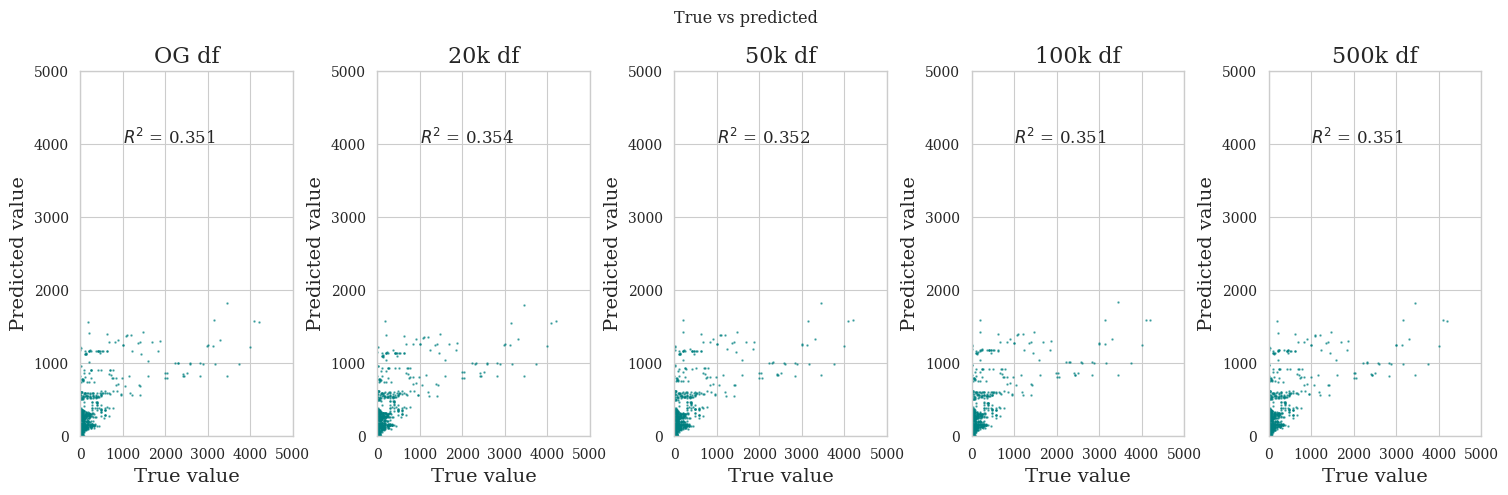

In [4]:
titles = ['OG df', '20k df', '50k df', '100k df', '500k df']

fig, ax = plt.subplots(ncols=len(titles), figsize=(15,5))
ax = ax.flatten()
fig.suptitle(f'True vs predicted')

for i in range(5):
    ax[i].plot(y_test, y_preds[i], '.', markersize=1.5, alpha=.6)
    ax[i].set(xlabel='True value', ylabel='Predicted value', title=titles[i], ylim=[0,5000], xlim=[0,5000])
    ax[i].text(1000, 4000, rf'$R^2$ = {r_squared[i]:.3f}', fontsize=12)

fig.tight_layout()

In [9]:
# instantiate regressor
ran_reg = RandomForestRegressor()

y_pred_list = []
r_sqrd_list = []
fis = []

for X, y in training_data:
    # fit and predict
    ran_reg.fit(X, y)
    y_pred = ran_reg.predict(X_test)
    
    # calculate the R^2 score
    rsquared = ran_reg.score(X_test, y_test)
    non_zero_mask = (y_test != 0)
    rel_error = np.mean(np.abs(y_test[non_zero_mask] - y_pred[non_zero_mask]) / y_test[non_zero_mask])
    rel_error_med = np.median(np.abs(y_test[non_zero_mask] - y_pred[non_zero_mask]) / y_test[non_zero_mask])
    rel_quan = np.quantile(np.abs(y_test[non_zero_mask] - y_pred[non_zero_mask]) / y_test[non_zero_mask], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    
    y_pred_list.append(y_pred)
    r_sqrd_list.append(rsquared)
    fis.append(ran_reg.feature_importances_)
    print(f'Relative error: {rel_error * 100 :.3f} %')
    print(f'Relative median error: {rel_error_med * 100 :.3f} %')
    print(rel_quan * 100, '%')
    print(f'R squared: {rsquared:.3f}')
    print()

Relative error: 145.180 %
Relative median error: 25.000 %
[ 2.          6.5        11.22       17.35186992 25.         34.
 44.96666667 58.35238095 93.92      ] %
R squared: 0.786

Relative error: 104.727 %
Relative median error: 29.111 %
[ 0.          2.25089606 10.         19.05454545 29.11111111 38.744
 50.         66.66666667 99.71428571] %
R squared: 0.756

Relative error: 98.004 %
Relative median error: 30.000 %
[  0.           1.           9.82        18.68        30.
  40.          50.          66.66666667 100.        ] %
R squared: 0.754

Relative error: 89.252 %
Relative median error: 30.000 %
[  0.           0.74933333   9.13184677  19.08311688  30.
  40.          50.          67.01538462 100.        ] %
R squared: 0.748

Relative error: 90.852 %
Relative median error: 30.000 %
[  0.           0.           6.92        17.54475703  30.
  40.06557377  50.          68.57233503 100.        ] %
R squared: 0.747



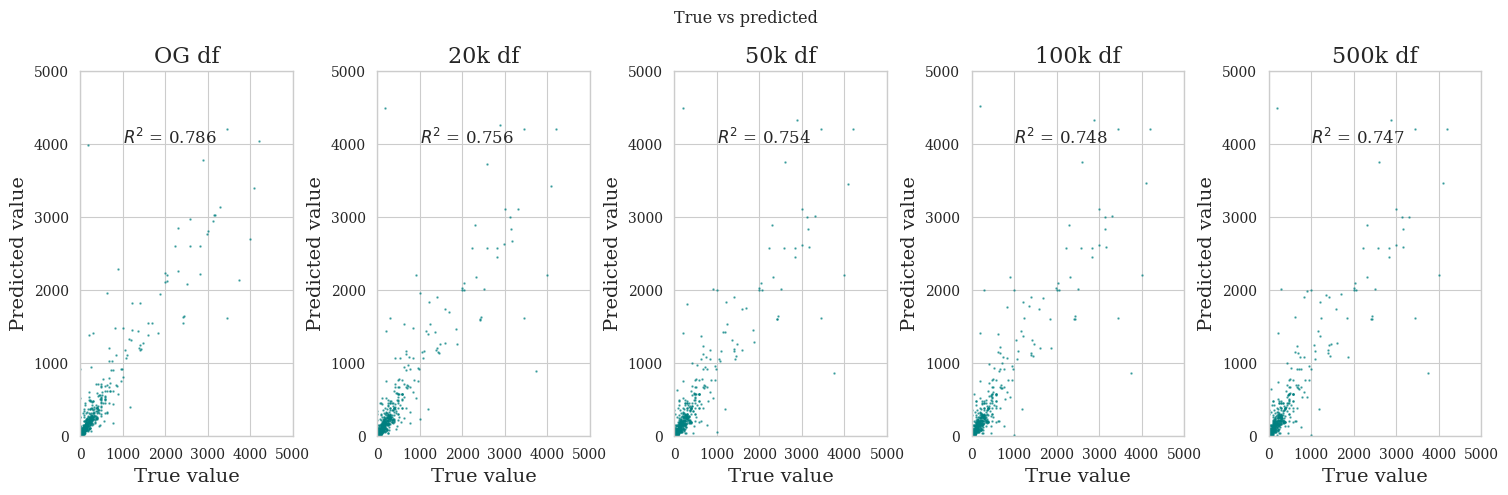

In [10]:
titles = ['OG df', '20k df', '50k df', '100k df', '500k df']

fig, ax = plt.subplots(ncols=len(titles), figsize=(15,5))
ax = ax.flatten()
fig.suptitle(f'True vs predicted')

for i in range(5):
    ax[i].plot(y_test, y_pred_list[i], '.', markersize=1.5, alpha=.6)
    ax[i].set(xlabel='True value', ylabel='Predicted value', title=titles[i], ylim=[0,5000], xlim=[0,5000])
    ax[i].text(1000, 4000, rf'$R^2$ = {r_sqrd_list[i]:.3f}', fontsize=12)

fig.tight_layout()

In [11]:
print(ran_reg.feature_importances_, df_resampled_100000.drop(['Volume', 'Account Description', 'Size', 'Year Month (after 2000) in Datetime', 'Value'], axis=1).columns)

print(len(ran_reg.feature_importances_))

[4.93636278e-02 4.89722774e-03 2.78996459e-03 3.81358057e-04
 1.73416830e-01 2.85590499e-01 1.59912387e-01 1.22938841e-01
 1.94442945e-03 1.98006530e-03 2.30602126e-03 2.34574284e-04
 4.97832005e-02 7.19208018e-02 2.76271675e-02 2.62279626e-04
 4.46507249e-02] Index(['Account Description ID', 'Type', 'Size Numeric', 'Strength (mg)',
       'WHO ATC 5 Code', 'Year Month (after 2000)', 'Region_Hovedstaden',
       'Region_Midtjylland', 'Region_Nordjylland', 'Region_Sjælland',
       'Region_Syddanmark', 'Product_Cimzia', 'Product_Inflectra',
       'Product_Remicade', 'Product_Remsima', 'Product_Stelara',
       'Product_Zessly'],
      dtype='object')
17


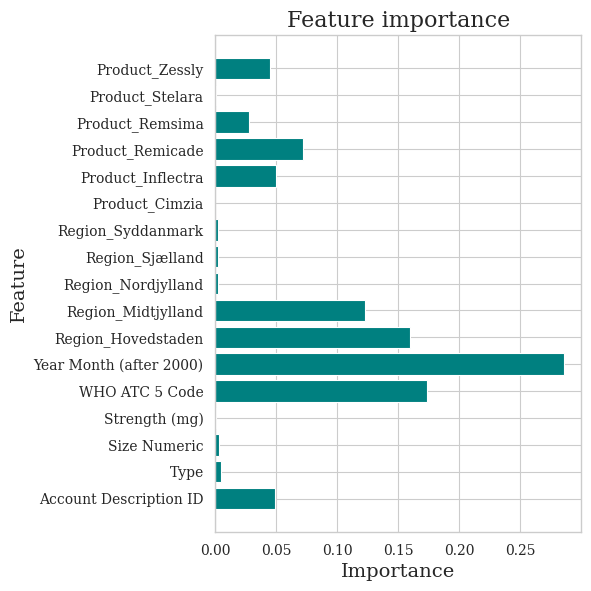

In [12]:
# show importance of features in a plot sorted by importance
fig, ax = plt.subplots()
ax.barh(df_resampled_100000.drop(['Volume', 'Account Description', 'Size', 'Year Month (after 2000) in Datetime', 'Value'], axis=1).columns, ran_reg.feature_importances_)
ax.set(xlabel = 'Importance', ylabel = 'Feature', title = 'Feature importance')
fig.tight_layout()
plt.show()

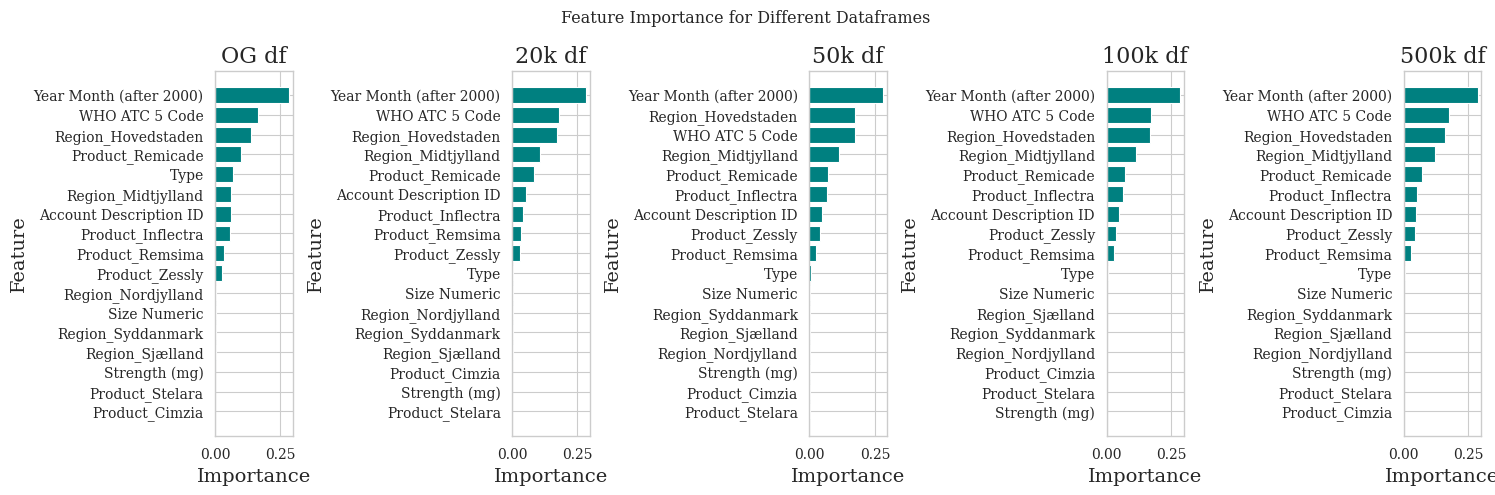

In [20]:
titles = ['OG df', '20k df', '50k df', '100k df', '500k df']
dataframes = [df, df_resampled_20000, df_resampled_50000, df_resampled_100000, df_resampled_500000]  # Replace with actual dataframe variables

fig, ax = plt.subplots(ncols=len(titles), figsize=(15, 5))
ax = ax.flatten()
fig.suptitle('Feature Importance for Different Dataframes')

for i in range(5):
    features = dataframes[i].drop(['Volume', 'Account Description', 'Size', 'Year Month (after 2000) in Datetime', 'Value'], axis=1).columns
    importances = fis[i]
    indices = np.argsort(importances)
    
    ax[i].barh(features[indices], importances[indices])
    ax[i].set(xlabel='Importance', ylabel='Feature', title=titles[i])

fig.tight_layout()
plt.show()

#### TODO: 

Sort feature importance in a list

xgboost //
ANN

Lav boxplot der viser resultatet for hver model
